Veri işleniyor...
Modeller eğitiliyor (biraz sürebilir)...

   2022 - 2023 TAHMİN KARŞILAŞTIRMA TABLOSU
        Tarih  Gerçek  Linear Regression  SVR (RBF Kernel)  Random Forest  \
0  2022-01-01    -2.1               0.48              0.28           0.95   
1  2022-02-01     1.5               1.00              2.04           3.11   
2  2022-03-01     0.7               5.63              6.56           6.98   
3  2022-04-01    13.7               9.45              9.30          11.11   
4  2022-05-01    15.4              18.14             16.27          17.38   
5  2022-06-01    21.0              21.64             20.53          21.02   
6  2022-07-01    22.7              24.48             23.77          24.09   
7  2022-08-01    25.8              22.13             23.23          24.21   
8  2022-09-01    20.1              21.44             21.06          18.07   
9  2022-10-01    13.2              14.26             14.77          13.28   
10 2022-11-01     8.4               8.08         

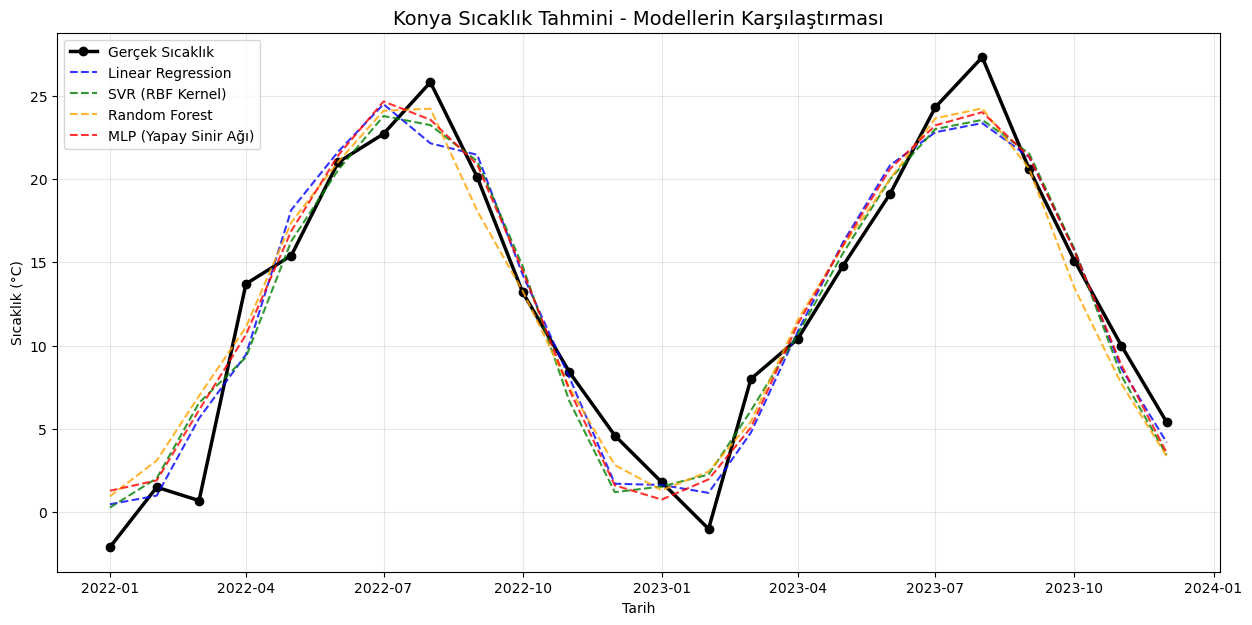

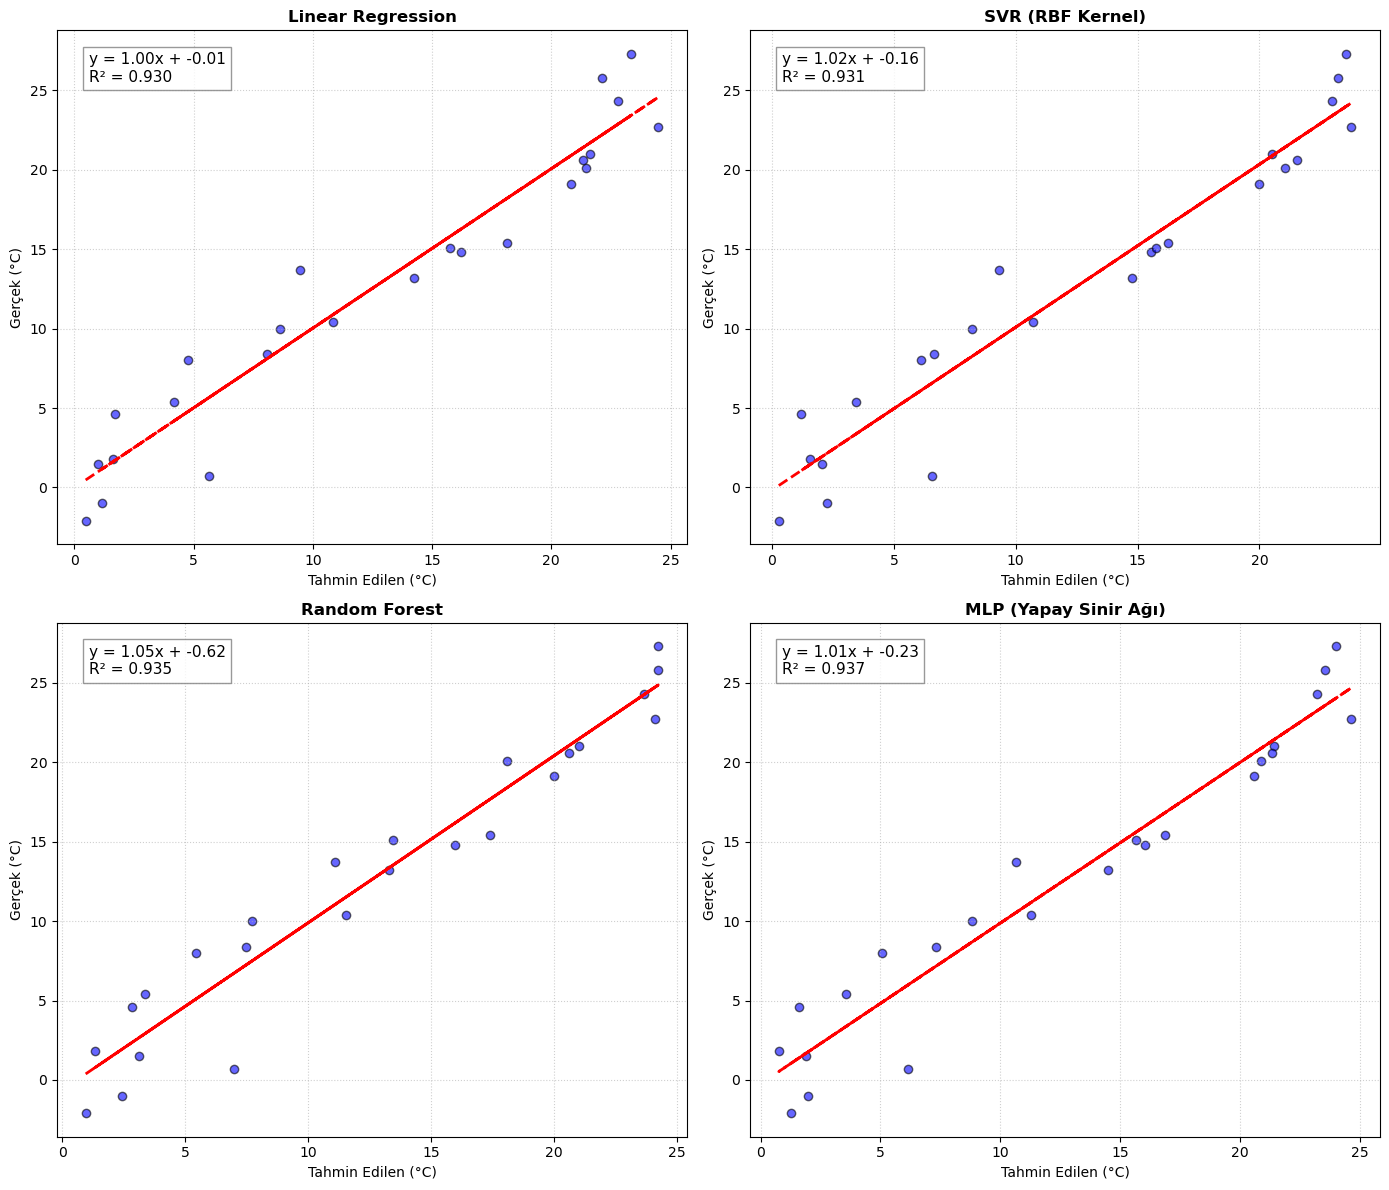

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# --- AYARLAR ---
file_path = "konya_veri.xlsx"

# 1. VERİYİ YÜKLEME VE DÜZENLEME
print("Veri işleniyor...")
try:
    df = pd.read_excel(file_path)
except FileNotFoundError:
    print(f"HATA: '{file_path}' dosyası bulunamadı! Dosya adını kontrol et.")
    raise

# Sütun isimlerini düzeltme
df.columns = ['Year', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

# Geniş tablodan uzun tabloya çevirme (Melt)
df_melted = pd.melt(df, id_vars=['Year'], var_name='Month', value_name='Temperature')
df_melted['Date'] = pd.to_datetime(df_melted['Year'].astype(str) + '-' + df_melted['Month'].astype(str) + '-01')
df_melted = df_melted.sort_values('Date').reset_index(drop=True)
df_final = df_melted[['Date', 'Temperature']]

# 2. MODEL HAZIRLIĞI (Pencereleme)
def create_sliding_window(data, window_size=12):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 12
temps = df_final['Temperature'].values
X, y = create_sliding_window(temps, window_size)

# Son 24 ayı (2022 ve 2023) test için ayır
test_size = 24
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]
test_dates = df_final['Date'].iloc[-test_size:]

# Veriyi Ölçeklendirme (Yapay Zeka modelleri için şart)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. MODELLERİ EĞİTME
models = {
    "Linear Regression": LinearRegression(),
    "SVR (RBF Kernel)": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "MLP (Yapay Sinir Ağı)": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=2000, random_state=42)
}

results_dict = {"Model": [], "R2 Score": [], "MAE": [], "RMSE": []}
predictions = {}

print("Modeller eğitiliyor (biraz sürebilir)...")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    predictions[name] = preds
    
    # Performans
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    results_dict["Model"].append(name)
    results_dict["R2 Score"].append(r2)
    results_dict["MAE"].append(mae)
    results_dict["RMSE"].append(rmse)

# 4. TABLOYU EKRANA BAS (TAM LİSTE)
comparison_df = pd.DataFrame({"Tarih": test_dates.values, "Gerçek": y_test})
for name, preds in predictions.items():
    comparison_df[name] = preds.round(2) # 2 basamak yuvarla

# Pandas ayarını değiştirip tüm satırları göster diyoruz
pd.set_option('display.max_rows', None)
print("\n" + "="*50)
print("   2022 - 2023 TAHMİN KARŞILAŞTIRMA TABLOSU")
print("="*50)
print(comparison_df)
print("="*50 + "\n")

# Model Performans Özeti
print("MODEL BAŞARI PUANLARI:")
print(pd.DataFrame(results_dict))

# 5. GRAFİK 1: ZAMAN SERİSİ (ÇİZGİ GRAFİK)
plt.figure(figsize=(15, 7))
plt.plot(comparison_df['Tarih'], comparison_df['Gerçek'], 'k-o', label='Gerçek Sıcaklık', linewidth=2.5)

colors = ['blue', 'green', 'orange', 'red']
for i, (name, preds) in enumerate(predictions.items()):
    plt.plot(comparison_df['Tarih'], preds, '--', label=name, color=colors[i], alpha=0.8)

plt.title("Konya Sıcaklık Tahmini - Modellerin Karşılaştırması", fontsize=14)
plt.xlabel("Tarih")
plt.ylabel("Sıcaklık (°C)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 6. GRAFİK 2: KORELASYON (SCATTER PLOT - PDF Sayfa 7 Tarzı)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (name, preds) in enumerate(predictions.items()):
    ax = axes[i]
    # Noktaları çiz
    ax.scatter(preds, y_test, color='blue', alpha=0.6, edgecolors='black')
    
    # Kırmızı trend çizgisi
    m, c = np.polyfit(preds, y_test, 1)
    ax.plot(preds, m*preds + c, color='red', linestyle='--', linewidth=2)
    
    # İstatistik kutusu
    r2_val = results_dict['R2 Score'][i]
    text_str = f"y = {m:.2f}x + {c:.2f}\nR² = {r2_val:.3f}"
    ax.text(0.05, 0.90, text_str, transform=ax.transAxes, 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), fontsize=11)
    
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_xlabel("Tahmin Edilen (°C)")
    ax.set_ylabel("Gerçek (°C)")
    ax.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

Model tüm geçmiş veriyle eğitiliyor...
Gelecek 24 ay tahmin ediliyor...

--- 2024 ve 2025 KONYA SICAKLIK TAHMİNİ ---
        Tarih  Tahmin_Sicaklik
0  2024-01-01         1.036986
1  2024-02-01         1.511761
2  2024-03-01         5.094334
3  2024-04-01         9.429599
4  2024-05-01        14.687698
5  2024-06-01        19.831967
6  2024-07-01        23.918299
7  2024-08-01        24.453643
8  2024-09-01        21.413595
9  2024-10-01        16.198199
10 2024-11-01         9.869589
11 2024-12-01         4.059280
12 2025-01-01         0.960346
13 2025-02-01         1.245817
14 2025-03-01         4.406604
15 2025-04-01         9.137341
16 2025-05-01        14.472459
17 2025-06-01        19.645139
18 2025-07-01        23.473870
19 2025-08-01        24.304540
20 2025-09-01        21.772927
21 2025-10-01        16.430917
22 2025-11-01         9.806945
23 2025-12-01         3.934383


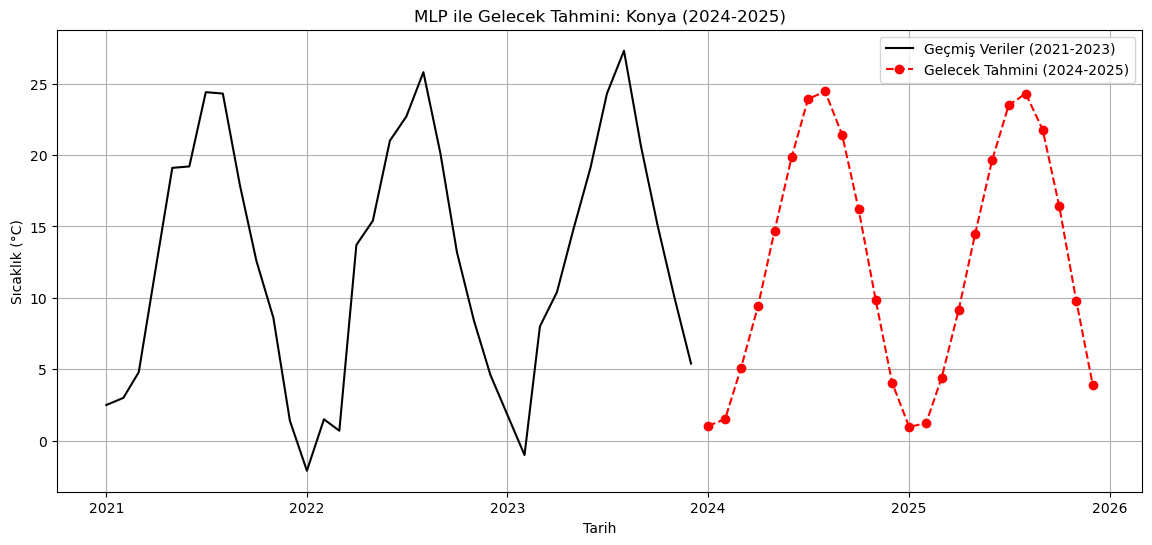

Tahminler 'gelecek_tahminleri_2024_2025.xlsx' dosyasına kaydedildi.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

# --- AYARLAR ---
file_path = "konya_veri.xlsx"
future_months = 24  # Kaç ay geleceği tahmin edelim? (2 Yıl = 24 Ay)

# 1. VERİYİ YÜKLE
df = pd.read_excel(file_path)
df.columns = ['Year', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

# Veriyi Düzleştirme
df_melted = pd.melt(df, id_vars=['Year'], var_name='Month', value_name='Temperature')
df_melted['Date'] = pd.to_datetime(df_melted['Year'].astype(str) + '-' + df_melted['Month'].astype(str) + '-01')
df_melted = df_melted.sort_values('Date').reset_index(drop=True)
all_temps = df_melted['Temperature'].values # Tüm geçmiş veriler

# 2. MODELİ EN GÜNCEL HALİYLE EĞİTME
# Modeli eğitmek için yine pencerelere böleceğiz ama bu sefer test ayırmıyoruz.
# Hepsini eğitime veriyoruz.
window_size = 12

def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

X_all, y_all = create_dataset(all_temps, window_size)

# Ölçeklendirme (MinMax - Yapay Sinir Ağı için kritik)
scaler = MinMaxScaler()
scaler.fit(X_all) # Ölçekleyiciyi tüm veriye göre ayarla
X_all_scaled = scaler.transform(X_all)

# En iyi modelimiz MLP (Yapay Sinir Ağı) idi, onu kullanalım
model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=2000, random_state=42)
print("Model tüm geçmiş veriyle eğitiliyor...")
model.fit(X_all_scaled, y_all)

# 3. GELECEĞİ TAHMİN ETME DÖNGÜSÜ
# Mantık şu: Son 12 ayı al -> Gelecek ayı tahmin et -> Tahmini listeye ekle -> Kaydır -> Tekrar et
last_window = all_temps[-window_size:] # Elimdeki en son 12 ay (2023)
future_predictions = []

current_window = last_window.reshape(1, -1) # Boyut düzeltme

print(f"Gelecek {future_months} ay tahmin ediliyor...")

for i in range(future_months):
    # Şu anki pencereyi ölçeklendir
    current_window_scaled = scaler.transform(current_window)
    
    # Tahmin yap
    pred = model.predict(current_window_scaled)[0]
    future_predictions.append(pred)
    
    # Pencereyi kaydır: En eskiyi at, yeni tahmini sona ekle
    # Örnek: [Ocak...Aralık] -> [Şubat...Aralık + YeniOcak]
    new_window = np.append(current_window[0][1:], pred)
    current_window = new_window.reshape(1, -1)

# 4. SONUÇLARI GÖRSELLEŞTİRME
# Tarihleri oluştur (2024-01'den başlayarak)
last_date = df_melted['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_months, freq='MS')

# Tablo oluştur
future_df = pd.DataFrame({'Tarih': future_dates, 'Tahmin_Sicaklik': future_predictions})
print("\n--- 2024 ve 2025 KONYA SICAKLIK TAHMİNİ ---")
print(future_df)

# Grafik Çiz
plt.figure(figsize=(14, 6))

# Geçmişten son 3 yılı gösterelim ki bağlantı görünsün
plt.plot(df_melted['Date'].iloc[-36:], df_melted['Temperature'].iloc[-36:], label='Geçmiş Veriler (2021-2023)', color='black')
plt.plot(future_df['Tarih'], future_df['Tahmin_Sicaklik'], label='Gelecek Tahmini (2024-2025)', color='red', linestyle='--', marker='o')

plt.title('MLP ile Gelecek Tahmini: Konya (2024-2025)')
plt.xlabel('Tarih')
plt.ylabel('Sıcaklık (°C)')
plt.legend()
plt.grid(True)
plt.show()

# İstersen Excel'e kaydet
future_df.to_excel("gelecek_tahminleri_2024_2025.xlsx", index=False)
print("Tahminler 'gelecek_tahminleri_2024_2025.xlsx' dosyasına kaydedildi.")

C:\Users\bilal\AppData\Local\Temp\ipykernel_10156\149791634.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Ay', y='Hata', data=comparison_df, ax=ax[1], palette="coolwarm", order=order)


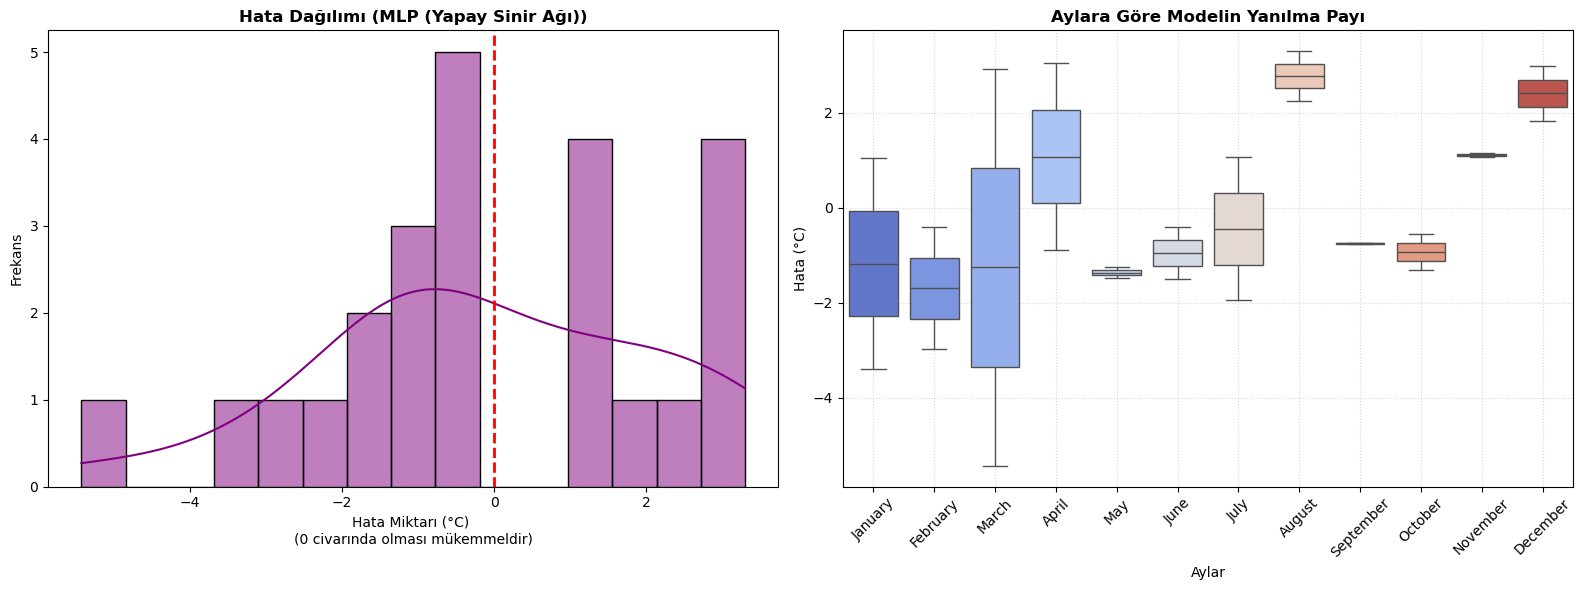

In [7]:
import seaborn as sns

# Önceki koddan 'comparison_df' tablosunun hafızada olduğunu varsayıyoruz.
# Eğer tablo yoksa hata verir, lütfen önce yukarıdaki "tahmin" kodlarını çalıştır.

# En iyi performansı gösteren modeli seçelim (Genelde MLP veya SVR çıkıyordu, grafikte onu baz alalım)
# Buraya senin en yüksek R2 veren modelinin adını yaz:
best_model_name = "MLP (Yapay Sinir Ağı)" 

# 1. Hataları (Residuals) Hesaplama
comparison_df['Hata'] = comparison_df['Gerçek'] - comparison_df[best_model_name]
comparison_df['Ay'] = comparison_df['Tarih'].dt.month_name() # Ayları isimlendir

# Grafik Çizimi
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# --- GRAFİK 1: HATA DAĞILIMI (HISTOGRAM) ---
sns.histplot(comparison_df['Hata'], kde=True, ax=ax[0], color='purple', bins=15)
ax[0].set_title(f'Hata Dağılımı ({best_model_name})', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Hata Miktarı (°C) \n(0 civarında olması mükemmeldir)')
ax[0].set_ylabel('Frekans')
ax[0].axvline(x=0, color='red', linestyle='--', linewidth=2) # 0 noktasına çizgi çek

# --- GRAFİK 2: AYLARA GÖRE HATA ANALİZİ (BOXPLOT) ---
# Ayları sıralı göstermek için
order = ['January', 'February', 'March', 'April', 'May', 'June', 
         'July', 'August', 'September', 'October', 'November', 'December']

sns.boxplot(x='Ay', y='Hata', data=comparison_df, ax=ax[1], palette="coolwarm", order=order)
ax[1].set_title('Aylara Göre Modelin Yanılma Payı', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Aylar')
ax[1].set_ylabel('Hata (°C)')
ax[1].tick_params(axis='x', rotation=45) # Yazıları eğik yap sığsın
ax[1].grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()